In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import time
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error



In [2]:
df = pd.read_csv('oxy.csv')
df_crude = pd.read_csv('CL=F.csv')

In [3]:
df.head(),df_crude.head()

(         Date       Open       High        Low      Close  Adj Close  Volume
 0  12/31/1981  11.347040  11.496737  11.197343  11.496737   1.751757  431705
 1    1/4/1982  11.496737  11.556616  11.376979  11.496737   1.751757  329624
 2    1/5/1982  11.376979  11.436858  11.317101  11.317101   1.724385  383274
 3    1/6/1982  11.317101  11.376979  11.257222  11.376979   1.733509  281819
 4    1/7/1982  11.317101  11.376979  11.257222  11.376979   1.733509  168674,
         Date       Open       High        Low      Close  Adj Close   Volume
 0  8/23/2000  31.950001  32.799999  31.950001  32.049999  32.049999  79385.0
 1  8/24/2000  31.900000  32.240002  31.400000  31.629999  31.629999  72978.0
 2  8/25/2000  31.700001  32.099998  31.320000  32.049999  32.049999  44601.0
 3  8/27/2000        NaN        NaN        NaN        NaN        NaN      NaN
 4  8/28/2000  32.040001  32.919998  31.860001  32.869999  32.869999  46770.0)

In [4]:
df.tail(),df_crude.tail()

(           Date       Open       High        Low      Close  Adj Close  \
 9870  2/24/2021  26.500000  28.680000  25.959999  28.160000  28.160000   
 9871  2/25/2021  28.170000  28.540001  26.450001  26.750000  26.750000   
 9872  2/26/2021  26.260000  27.010000  25.209999  26.610001  26.610001   
 9873   3/1/2021  27.370001  28.280001  27.010000  27.639999  27.639999   
 9874   3/2/2021  27.590000  28.510000  27.320000  27.820000  27.820000   
 
         Volume  
 9870  27789000  
 9871  21142500  
 9872  21615400  
 9873  15865000  
 9874  16531500  ,
            Date       Open       High        Low      Close  Adj Close  \
 6293  2/25/2021  63.389999  63.810001  62.650002  63.529999  63.529999   
 6294  2/26/2021  63.459999  63.570000  61.340000  61.500000  61.500000   
 6295  2/28/2021        NaN        NaN        NaN        NaN        NaN   
 6296   3/1/2021  61.950001  62.919998  59.959999  60.639999  60.639999   
 6297   3/2/2021  60.230000  61.209999  59.380001  59.750000  59

In [5]:
df.shape,df_crude.shape

((9875, 7), (6298, 7))

In [6]:
df_crude = df_crude.dropna()  #remove all nulls 
df_crude.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,8/23/2000,31.950001,32.799999,31.950001,32.049999,32.049999,79385.0
1,8/24/2000,31.900000,32.240002,31.400000,31.629999,31.629999,72978.0
2,8/25/2000,31.700001,32.099998,31.320000,32.049999,32.049999,44601.0
4,8/28/2000,32.040001,32.919998,31.860001,32.869999,32.869999,46770.0
5,8/29/2000,32.820000,33.029999,32.560001,32.720001,32.720001,49131.0


In [7]:
merge=pd.merge(df,df_crude, how='inner', on='Date')#merge two dataframe by same dates
merge.shape

(5117, 13)

In [8]:
merge.dtypes

Date            object
Open_x         float64
High_x         float64
Low_x          float64
Close_x        float64
Adj Close_x    float64
Volume_x         int64
Open_y         float64
High_y         float64
Low_y          float64
Close_y        float64
Adj Close_y    float64
Volume_y       float64
dtype: object

In [9]:
merge.isnull().sum()  #no null values in dataframe

Date           0
Open_x         0
High_x         0
Low_x          0
Close_x        0
Adj Close_x    0
Volume_x       0
Open_y         0
High_y         0
Low_y          0
Close_y        0
Adj Close_y    0
Volume_y       0
dtype: int64

In [10]:
merge.info() #confirm with no nulls

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5117 entries, 0 to 5116
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         5117 non-null   object 
 1   Open_x       5117 non-null   float64
 2   High_x       5117 non-null   float64
 3   Low_x        5117 non-null   float64
 4   Close_x      5117 non-null   float64
 5   Adj Close_x  5117 non-null   float64
 6   Volume_x     5117 non-null   int64  
 7   Open_y       5117 non-null   float64
 8   High_y       5117 non-null   float64
 9   Low_y        5117 non-null   float64
 10  Close_y      5117 non-null   float64
 11  Adj Close_y  5117 non-null   float64
 12  Volume_y     5117 non-null   float64
dtypes: float64(11), int64(1), object(1)
memory usage: 559.7+ KB


In [11]:
df = merge[['Date','Open_x','High_x','Low_x','Close_x','Adj Close_x','Volume_x','Open_y']]
df = df.rename({'Date':'date','Open_x': 'open', 'High_x': 'high','Low_x':'low','Close_x':'close',\
                 'Adj Close_x':'adj_close','Volume_x':'volume','Open_y':'crude_price'}, axis=1)


In [12]:
df.head()

,date,open,high,low,close,adj_close,volume,crude_price
0,8/23/2000,10.299160,10.628494,10.299160,10.553645,5.639605,4012060,31.950001
1,8/24/2000,10.359039,10.388979,10.119524,10.179403,5.439622,1910942,31.900000
2,8/25/2000,10.209342,10.359039,9.969827,10.269221,5.487617,1096589,31.700001
3,8/28/2000,10.269221,10.448857,10.149463,10.269221,5.487617,1806774,32.040001
4,8/29/2000,10.239281,10.299160,10.179403,10.246766,5.475616,1148569,32.820000


In [13]:
df = df[['date','close','crude_price']].copy()

In [14]:
df.head(), df.tail()

(        date      close  crude_price
 0  8/23/2000  10.553645    31.950001
 1  8/24/2000  10.179403    31.900000
 2  8/25/2000  10.269221    31.700001
 3  8/28/2000  10.269221    32.040001
 4  8/29/2000  10.246766    32.820000,            date      close  crude_price
 5112  2/24/2021  28.160000    61.290001
 5113  2/25/2021  26.750000    63.389999
 5114  2/26/2021  26.610001    63.459999
 5115   3/1/2021  27.639999    61.950001
 5116   3/2/2021  27.820000    60.230000)

In [15]:
df.describe()

,close,crude_price
count,5117.000000,5117.000000
mean,55.167199,61.745079
std,27.916449,25.811546
min,8.880000,-14.000000
25%,26.792189,41.630001
50%,62.880001,58.320000
75%,77.720001,81.720001
max,110.886032,145.190002


Text(0.5, 1.0, 'oxy Autocorrelation plot')

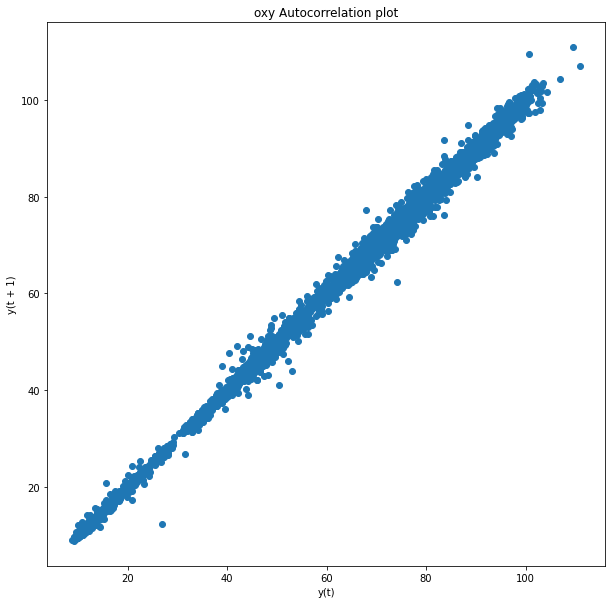

In [16]:
#strong autocorrelation with lag one-a good fit for arima model
plt.figure(figsize=(10,10))
lag_plot(df.close, lag=1)
plt.title('oxy Autocorrelation plot')

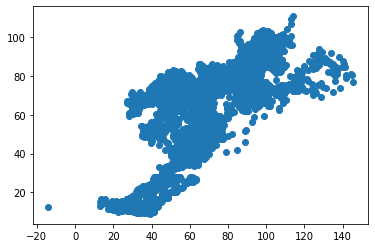

In [17]:
plt.scatter(df.crude_price, df.close) #display some positive correlation 

In [18]:
#stationary test using ADF test, p<0.05 shows NOT stationary
#which means the stock price depends on time. 
#we will need to find the order of differencing

result = adfuller(df.close.dropna())
print("ADF statistic"+str(result[0]))
print("p-value"+str(result[1]))

ADF statistic-1.7652586005358097
p-value0.3978410711381649


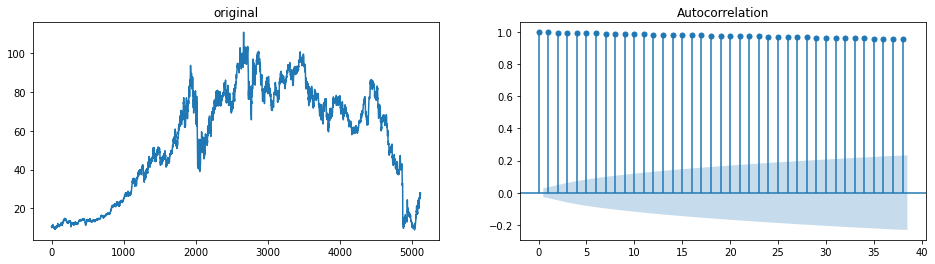

In [19]:
#ACF plot
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,4))

ax1.plot(df.close)
ax1.set_title('original')
plot_acf(df.close,ax2);


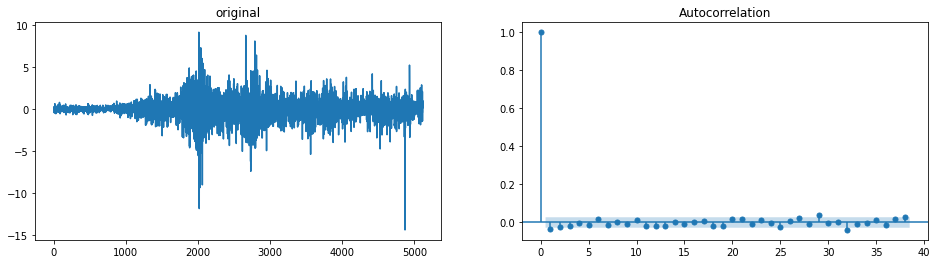

In [20]:
#differencing once
diff = df.close.diff().dropna()
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,4))

ax1.plot(diff)
ax1.set_title('original')
plot_acf(diff,ax2);


In [21]:
#now check stationality using Adfuller test
result = adfuller(diff)
print("ADF statistic"+str(result[0]))
print("p-value"+str(result[1]))

ADF statistic-52.624185322959505
p-value0.0


In [46]:
#use log-return to check stationality using Adufuller test
df_log = np.log(df.close/df.close.shift(1)).dropna()
result = adfuller(df_log)
print("ADF statistic"+str(result[0]))
print("p-value"+str(result[1]))

ADF statistic-12.433624053251322
p-value3.890712174542137e-23


In [49]:
df_log

1      -0.036105
2       0.008785
3       0.000000
4      -0.002189
5      -0.013235
          ...   
5112    0.077501
5113   -0.051368
5114   -0.005247
5115    0.037977
5116    0.006491
Name: close, Length: 5116, dtype: float64

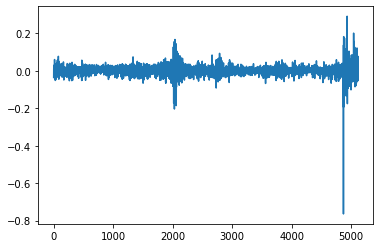

In [50]:
#clearly it is stationary
df_log.plot()
plt.show()

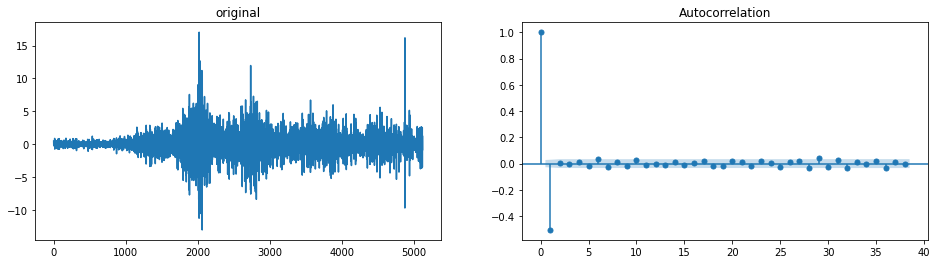

In [23]:
#differencing twice
diff = df.close.diff().diff().dropna()
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,4))

ax1.plot(diff)
ax1.set_title('original')
plot_acf(diff,ax2);

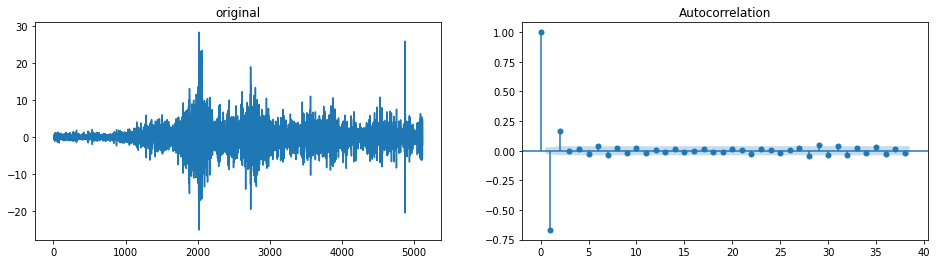

In [24]:
#differencing third time
diff = df.close.diff().diff().diff().dropna()
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,4))

ax1.plot(diff)
ax1.set_title('original')
plot_acf(diff,ax2);

In [25]:
#use pmdarima package to find the number of differencing
ndiffs(df.close, test='adf')

1

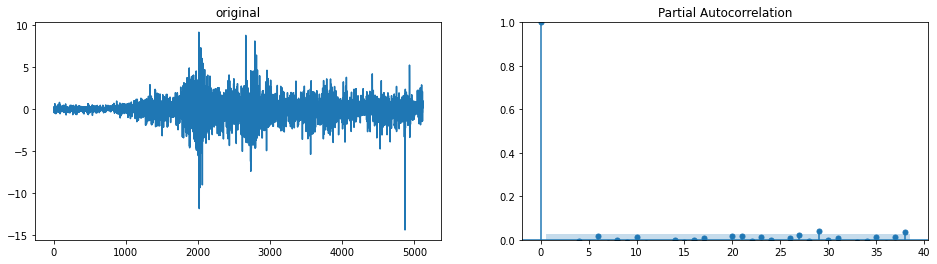

In [26]:
# p is the order of auto regression(AR) term, referring to the number of lags to be used for predictors
# I use partial autoregression plot(PACF) to find p
# partial autoregression shows the correlation between the series and lags
diff = df.close.diff().dropna()
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,4))

ax1.plot(diff)
ax1.set_title('original')
ax2.set_ylim(0,1)
plot_pacf(diff,ax2);

pacf lag of 39 is above the significant line

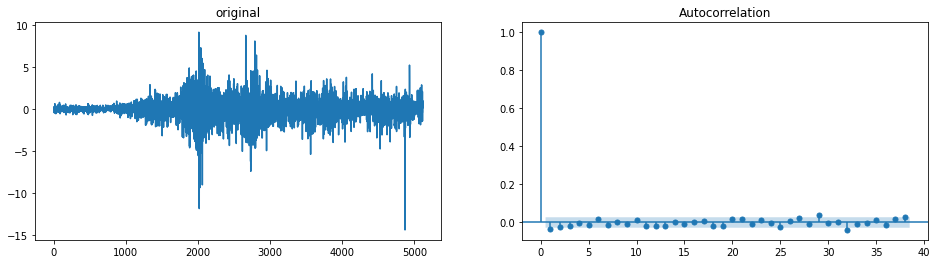

In [27]:
#q is the order of moving average(MA) term, shows the number of lagged forcast errors that 
#should go into the ARIMA model
#can be found by looking at acf plot
diff = df.close.diff().dropna()
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,4))

ax1.plot(diff)
ax1.set_title('original')
plot_acf(diff,ax2);

In [28]:
#smape(Symmetric mean absolute percentage error)
#is commonly used as loss function for time series data
def smape(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

In [29]:
#split data 80%-20%
train_data, test_data = df[0:int(len(df)*0.8)], df[int(len(df)*0.8):]
X_train = train_data.close.values
X_test = test_data.close.values
X_train.shape, X_test.shape

((4093,), (1024,))

$AIC = -2 \frac{\ln L}{T} + \frac{2} {T}K $ \
$BIC = -2 \frac{\ln L}{T} + \frac{\ln T} {T}K$ \
where $\ln L$ is the log likewood of estimated model, \
k is the number of parameters \
T is the length of time series \
low AIC and BIC implies better models. 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13536.929, Time=2.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13555.149, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13546.920, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13546.119, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13553.662, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=13536.927, Time=1.70 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=13542.670, Time=0.34 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13535.927, Time=1.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13536.960, Time=1.37 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=13543.608, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=13534.820, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=13544.694, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=13545.486, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=13535.887, Time=0.57 sec
 ARIMA(1,1,2)(0,0,0

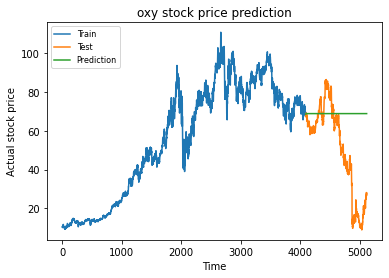

In [30]:
#built model using auto ARIMA to find optimal parameters
model = auto_arima(X_train, trace=True, error_function='ignore',suppress_warning=True)
model.fit(X_train)
forecast= model.predict(n_periods=len(X_test))
forecast =pd.DataFrame(forecast,test_data.index,columns=['Prediction'])
#plot the graph
plt.plot(train_data.index,X_train, label='Train')
plt.plot(test_data.index,X_test,label='Test')
plt.plot(forecast,label='Prediction')
plt.title('oxy stock price prediction')
plt.xlabel('Time')
plt.ylabel('Actual stock price')
plt.legend(loc='upper left',fontsize=8)
plt.show()

In [68]:
model = SARIMAX(df.close, exog=df.crude_price, order=(1,1,1))
results = model.fit()
data_exog = [60]*30
mean_forecast = results.get_forecast(steps=30, exog=data_exog).predicted_mean
print(mean_forecast)

5117    27.778902
5118    27.759853
5119    27.749721
5120    27.744333
5121    27.741467
5122    27.739942
5123    27.739131
5124    27.738700
5125    27.738471
5126    27.738349
5127    27.738284
5128    27.738249
5129    27.738231
5130    27.738221
5131    27.738216
5132    27.738213
5133    27.738212
5134    27.738211
5135    27.738211
5136    27.738210
5137    27.738210
5138    27.738210
5139    27.738210
5140    27.738210
5141    27.738210
5142    27.738210
5143    27.738210
5144    27.738210
5145    27.738210
5146    27.738210
Name: predicted_mean, dtype: float64


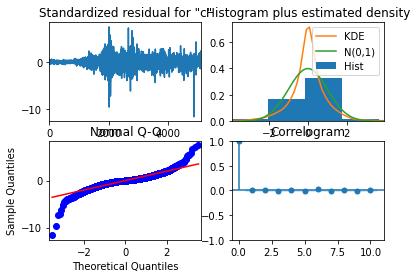

In [69]:
#plot results
results.plot_diagnostics()
plt.show()

In [51]:
#use log-transform to make model and see if it is better
model2 = auto_arima(df_log, trace=True, error_function='ignore',suppress_warning=True)
model2.fit(df_log)
model

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-22666.246, Time=3.19 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-22665.419, Time=0.49 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-22667.474, Time=0.88 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-22667.478, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-22667.156, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-22665.478, Time=0.35 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-22665.463, Time=0.40 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-22667.826, Time=2.65 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-22666.849, Time=1.91 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-22663.593, Time=1.38 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-22663.477, Time=0.74 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-22669.496, Time=4.58 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-22664.746, Time=6.42 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=-22665.060, Time=2.92 sec
 ARIM

In [61]:
model3 = SARIMAX(df_log, order=(0,0,5))
results2 = model3.fit()
mean_forecast = results.get_forecast(steps=30).predicted_mean
print(mean_forecast)

C:\Users\zcj10\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\zcj10\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


5116    0.003865
5117   -0.000905
5118   -0.001549
5119    0.000562
5120    0.000343
5121    0.000000
5122    0.000000
5123    0.000000
5124    0.000000
5125    0.000000
5126    0.000000
5127    0.000000
5128    0.000000
5129    0.000000
5130    0.000000
5131    0.000000
5132    0.000000
5133    0.000000
5134    0.000000
5135    0.000000
5136    0.000000
5137    0.000000
5138    0.000000
5139    0.000000
5140    0.000000
5141    0.000000
5142    0.000000
5143    0.000000
5144    0.000000
5145    0.000000
Name: predicted_mean, dtype: float64


C:\Users\zcj10\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [57]:
np.exp(mean_forecast.cumsum())*27.82

5116    27.927726
5117    27.902476
5118    27.859291
5119    27.874939
5120    27.884513
5121    27.884513
5122    27.884513
5123    27.884513
5124    27.884513
5125    27.884513
5126    27.884513
5127    27.884513
5128    27.884513
5129    27.884513
5130    27.884513
5131    27.884513
5132    27.884513
5133    27.884513
5134    27.884513
5135    27.884513
5136    27.884513
5137    27.884513
5138    27.884513
5139    27.884513
5140    27.884513
5141    27.884513
5142    27.884513
5143    27.884513
5144    27.884513
5145    27.884513
Name: predicted_mean, dtype: float64

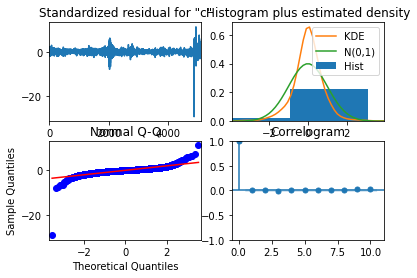

In [62]:
results2.plot_diagnostics()
plt.show()

In [32]:

history = [x for x in X_train]
print(type(history))
predictions = list()
for t in range(len(X_test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = X_test[t]
    history.append(obs)
error = mean_squared_error(X_test, predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape(X_test, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)

<class 'list'>
Testing Mean Squared Error: 1.196
Symmetric mean absolute percentage error: 2.056


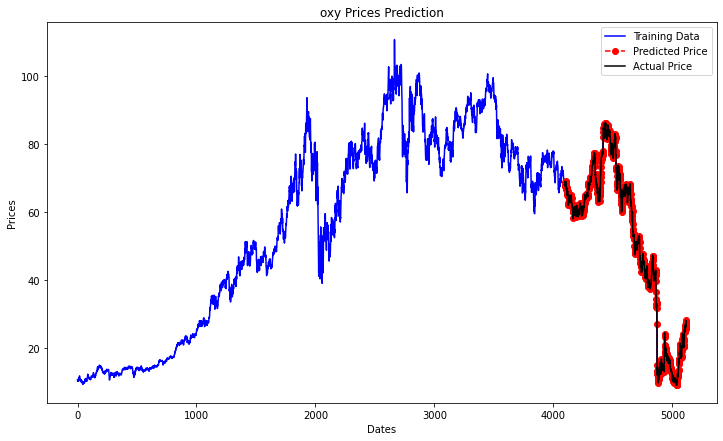

In [33]:
plt.figure(figsize=(12,7))
plt.plot(df.close, 'green', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='red', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, X_test, color='black', label='Actual Price')
plt.title('oxy Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
#plt.xticks(np.arange(0,5117, 1300), df['Date'][0:5117:1300])
plt.legend()

In [34]:
X_crude_train = df.crude_price[:int(df.shape[0]*0.8)]
X_crude_test = df.crude_price[int(df.shape[0]*0.8):]
X_crude_train.shape, X_crude_test.shape

((4093,), (1024,))

In [35]:
#now compare with ARIMA model using an exogenous, a outside factor
X_crude_test = X_crude_test.values
history = [x for x in X_train]
crude_hist = [x for x in X_crude_train]
print(type(history))
predictions = list()
for t in range(len(X_test)):
    crude_obs = X_crude_test[t]
    model = ARIMA(history, order=(1,1,1),exog=crude_hist)
    model_fit = model.fit()
    output = model_fit.forecast(steps=1,exog=crude_obs, dynamic=True)
    yhat = output[0]
    predictions.append(yhat)
    obs = X_test[t]
    history.append(obs)
    crude_hist.append(crude_obs)
error = mean_squared_error(X_test, predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape(X_test, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)

<class 'list'>
Testing Mean Squared Error: 1.196
Symmetric mean absolute percentage error: 2.054


In [36]:
predictions #this prediction

[68.64729608716185,
 68.06590932592997,
 67.93994717682345,
 68.17877640271303,
 68.57322050883788,
 68.95341480217687,
 67.92908282367861,
 67.81652979151302,
 67.65647494981307,
 68.50151348084934,
 69.15192704416583,
 68.20901903472148,
 66.89603919184184,
 66.83691675777447,
 68.18543765065002,
 68.45389041882831,
 67.42337769827,
 67.19862919762967,
 67.24083561127256,
 66.50008791107604,
 66.32877531792562,
 66.99921672589588,
 65.97325925891322,
 65.3328332972462,
 64.97649696405146,
 65.51856433807964,
 65.58801487643822,
 66.24242189853143,
 65.53440965874904,
 64.91736082092503,
 64.7846896620056,
 64.74797499854928,
 62.216262400081035,
 62.614153945004674,
 62.69284897397366,
 62.94693500140041,
 63.09005893268312,
 65.01483592545965,
 63.83517213047662,
 64.09108311212188,
 63.67973340642734,
 63.39020051745624,
 63.52905260544989,
 63.07688602966806,
 62.870919180989,
 62.902916520705176,
 63.40480039780371,
 63.76748755807296,
 64.23769473114785,
 63.372647581188325,
 63

In [37]:
#now use whole data as training data and predict future 30 days
history = [x for x in df.close]
predictions = list()
for t in range(30):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    history.append(yhat)
predictions

[27.7880594049248,
 27.76556171322548,
 27.749715450090093,
 27.738553713274136,
 27.73069189430435,
 27.725154379388833,
 27.7212539968259,
 27.718506736556034,
 27.716571684730887,
 27.715208717133937,
 27.714248701025774,
 27.713572506687928,
 27.71309622419375,
 27.712760751072956,
 27.712524458098375,
 27.71235802339614,
 27.71224079386142,
 27.712158222365048,
 27.712100062512373,
 27.712059097186074,
 27.712030242947076,
 27.712009919247585,
 27.711995604096526,
 27.71198552111171,
 27.71197841908547,
 27.71197341671928,
 27.71196989326437,
 27.711967411492115,
 27.711965663436985,
 27.71196443218081]

In [38]:
#build model using crude_oil as exogenous(outside factors)
#An optional 2-d array of exogenous variables. 
#If provided, these variables are used as additional features in the regression operation. 
crude_price = df.crude_price.values.reshape(-1, 1)
model2 = auto_arima(df.close, exogenous=crude_price,trace=True, error_function='ignore',suppress_warning=True)
model.fit(df.close)
forecast= model.predict(n_periods=30)
forecast =pd.DataFrame(forecast, columns=['Prediction'])
forecast

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16659.685, Time=0.98 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16665.175, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16658.856, Time=0.36 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16658.282, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16663.213, Time=0.47 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16655.771, Time=1.44 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16657.620, Time=0.96 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16657.723, Time=0.66 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=16657.362, Time=0.52 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16657.821, Time=0.46 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=16653.815, Time=1.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=16656.321, Time=0.31 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=16656.895, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=16655.460, Time=1.48 sec
 ARIMA(1,1,2)(0,0,0

C:\Users\zcj10\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\tools.py:538: RuntimeWarning: invalid value encountered in sqrt
  x = r / ((1 - r**2)**0.5)
C:\Users\zcj10\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


TypeError: predict() missing 1 required positional argument: 'params'

In [ ]:
model2.summary()

In [ ]:
model3 = ARIMA(df.close, order=(1,1,1))
model.fit(df.close)
forecast= model.predict(n_periods=30)
forecast =pd.DataFrame(forecast, columns=['Prediction'])
forecast